# Matheus do Ó

In [1]:
using Distributed
addprocs(11);

In [2]:
@everywhere begin
    using FileIO
    using Images
    include("auxiliary_functions.jl")
    include("color_functions.jl")
end

In [3]:
@everywhere begin
    palette_img = 0
    best_img = 0
    index_img = 0
    
    palette_size = 64
    number_neighbours = 50
    number_changes_local_search = 16
    threshold = nprocs()
    max_iter = nprocs() * 5

    img = FileIO.load("./naruto.jpg")
    img_matrix = channelview(img);
end

In [4]:
function display_images(imgs)
    for (i, img) in enumerate(imgs)
        println("iter $(img[2]):")
        display(colorview(RGB, img[1]))
    end
end

display_images (generic function with 1 method)

In [5]:
@everywhere function grasp_iter(args)
    #organize args
    f=args[1]
    random_greedy=args[2]
    local_search=args[3]
    iter=args[4]
    number_changes_local_search=args[5]
    verbose=args[6]

    #get a random-greedy palette
    global palette_img, index_img, palette = random_greedy(palette_img, index_img)

    #get the best palette found in local search
    f_x = f(palette_img)
    global best_img, f_val = local_search(f_x, palette_img, index_img, palette, number_changes_local_search, best_img)
    return palette_img, f_val
end

function parallel_grasp(f, random_greedy, local_search, palette_size, number_changes_local_search, threshold, max_iter=100, verbose=0)
    iter = 1
    χ = Inf
    f_χ = Inf

    #initialize
    imgs = []
    vals = []
    minimum_vals = []
    procs_number = nprocs()
    original_number_changes_local_search = number_changes_local_search
    unchanged = 0
    increment = Int(round(palette_size / 10))

    @everywhere begin
        global palette_img = zeros(size(img_matrix))
        global index_img = zeros(Int64, size(img_matrix, 2), size(img_matrix, 3))
        global best_img = zeros(size(img_matrix))
    end
    
    while iter <= max_iter
        args_gen = x -> [f, random_greedy, local_search, x, number_changes_local_search, verbose]

        #send jobs to the processors
        args = []
        for i in 0:procs_number-1
            push!(args, args_gen(iter+i))
        end
        answers = pmap(grasp_iter, args)

        #get the answer of each processor and see if there's
        #a new local minimum
        for (i, ans) in enumerate(answers)
            new_img, f_val = ans
            if f_val < f_χ
                χ = new_img
                f_χ = f_val
                push!(imgs, (χ, iter+i-1))
            else
                unchanged+=1
            end
            if verbose == 1
                println("iteration $(iter+i-1) starting! f(χ) = $f_χ")
            end
            push!(vals, f_val)
            push!(minimum_vals, f_χ)
        end

        #checking if it's necessary to expand the number_changes_local_search number
        if unchanged >= threshold && number_changes_local_search + increment <= palette_size
                new_val = number_changes_local_search + increment
                if number_changes_local_search == original_number_changes_local_search && 2number_changes_local_search <= palette_size
                    new_val = 2number_changes_local_search
                end
                if verbose==1
                    println("number of number_changes_local_search changed from $number_changes_local_search to $new_val")
                end
                number_changes_local_search = new_val
                unchanged=0
        else
            if verbose==1
                println("number of number_changes_local_search changed from $number_changes_local_search to $original_number_changes_local_search")
            end
            number_changes_local_search = original_number_changes_local_search
        end

        #sum iterations
        iter+=procs_number
    end
    return imgs, vals, minimum_vals
end

parallel_grasp (generic function with 3 methods)

In [6]:
function process_image(img_matrix, display=0)
    @everywhere colors_count = count_colors(img_matrix)
    @everywhere possible_colors, pizza = construct_pizza(colors_count)

    @everywhere f = x -> dist_img(x, img_matrix)
    @everywhere ls = (f_val, palette_img, index_img, palette, number_changes_local_search, best_img) -> change_palette(f, possible_colors,
                                                    pizza, f_val,
                                                    img_matrix, palette_img,
                                                    index_img, palette,
                                                    number_changes_local_search, best_img, number_neighbours)
    @everywhere rg = (palette_img, index_img) -> quantize(img_matrix, palette_img, index_img, possible_colors', pizza, palette_size)

    @time begin
        final_imgs, vals = parallel_grasp(f, rg, ls, palette_size,
                                          number_changes_local_search, threshold, max_iter, 1);
    end
    if display == 1
        display_images(final_imgs)
    end

    return final_imgs, vals
end

process_image (generic function with 2 methods)

iteration 1 starting! f(χ) = 274.5047877691632
iteration 2 starting! f(χ) = 274.5047877691632
iteration 3 starting! f(χ) = 274.5047877691632
iteration 4 starting! f(χ) = 274.5047877691632
iteration 5 starting! f(χ) = 274.5047877691632
iteration 6 starting! f(χ) = 274.5047877691632
iteration 7 starting! f(χ) = 274.5047877691632
iteration 8 starting! f(χ) = 274.5047877691632
iteration 9 starting! f(χ) = 274.5047877691632
iteration 10 starting! f(χ) = 274.5047877691632
iteration 11 starting! f(χ) = 274.5047877691632
iteration 12 starting! f(χ) = 183.34265657309234
number of number_changes_local_search changed from 16 to 16
iteration 13 starting! f(χ) = 183.34265657309234
iteration 14 starting! f(χ) = 183.34265657309234
iteration 15 starting! f(χ) = 183.34265657309234
iteration 16 starting! f(χ) = 169.94779368890002
iteration 17 starting! f(χ) = 169.94779368890002
iteration 18 starting! f(χ) = 169.94779368890002
iteration 19 starting! f(χ) = 169.94779368890002
iteration 20 starting! f(χ) =

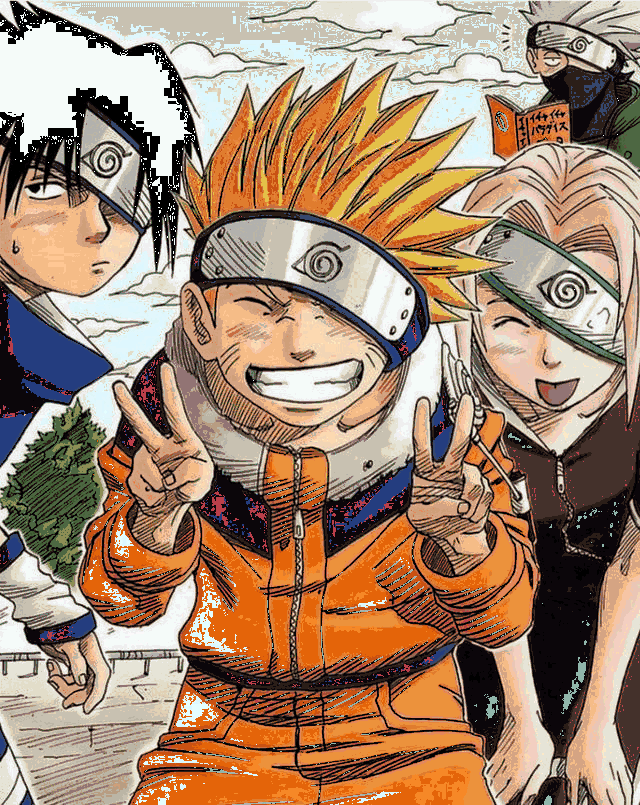

iter 12:


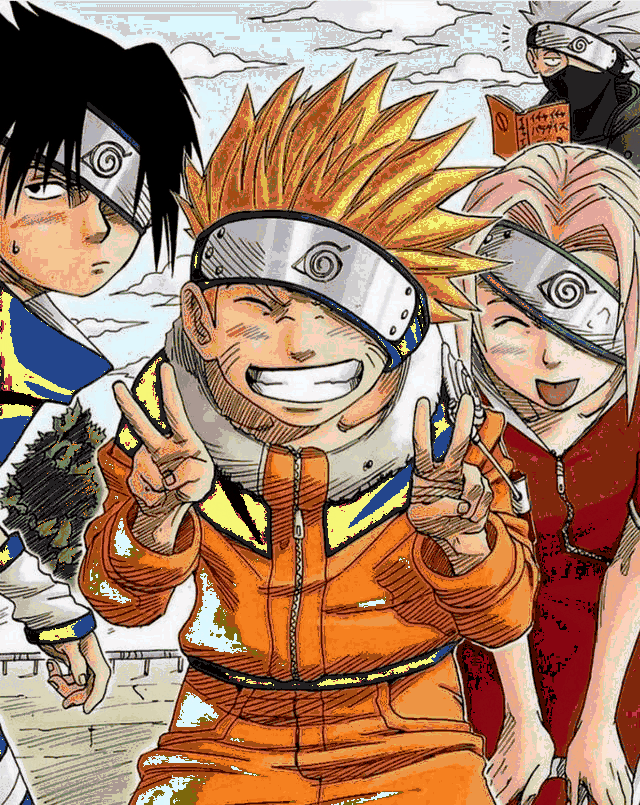

iter 16:


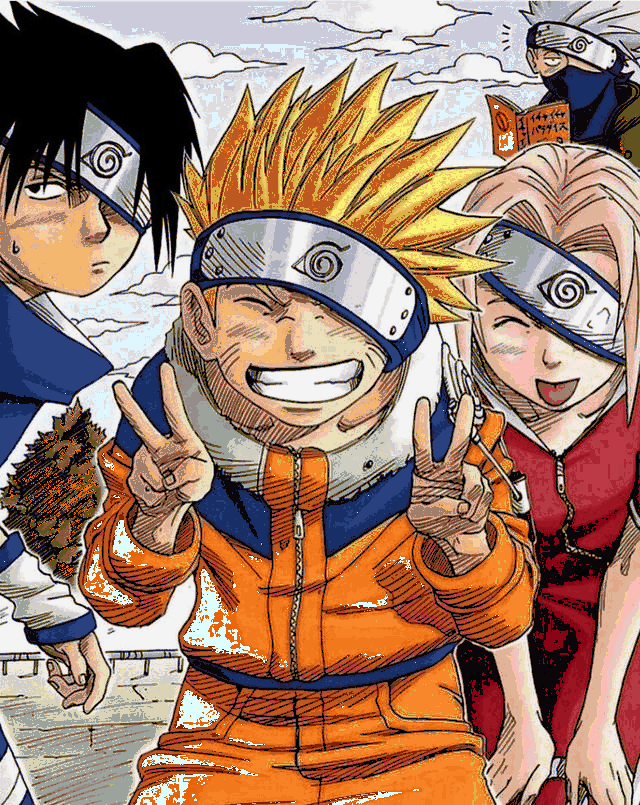

iter 26:


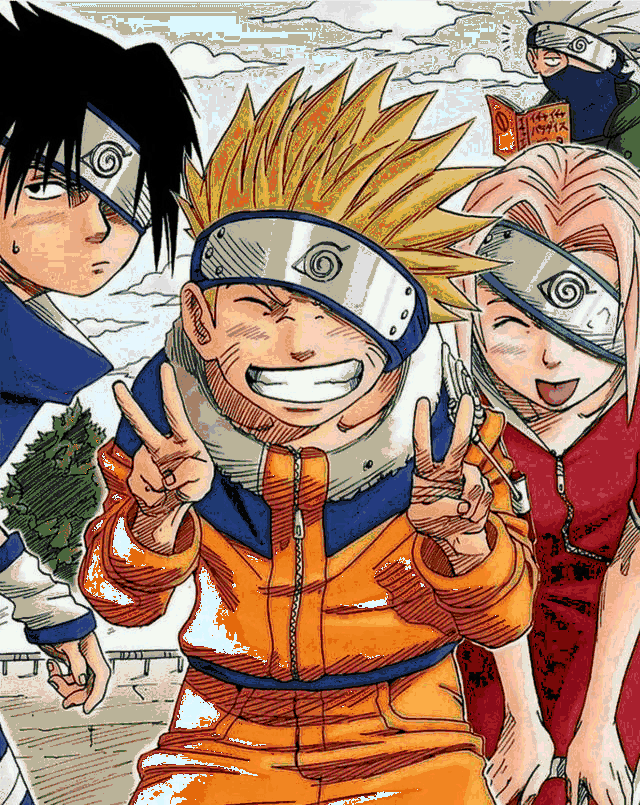

In [7]:
final_imgs, vals = process_image(img_matrix, 1);